 # Build a Reddit Post Recommender
 For demonstration purpose, this script only uses posts from the 'science' subreddit

In [1]:
# Import other packages
# Data
from itertools import count
import pandas as pd
import numpy as np
# import datetime as dt

# SQL
import psycopg2

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import spacy
# from spacy.lang.en import English

# Scikit-learn
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

 ## Extract Data From PostgreSQL Database
 Reddit posts were searched and stored in the database in the script reddit_search_store.py

In [2]:
# Establish the connection
try:
    conn = psycopg2.connect(
        user='postgres', password='', host='localhost', port= '5432'
    ) # database='postgres', 
    print("Postgres server is connected")
    
    conn.autocommit = True
    cursor = conn.cursor() # Create a cursor object using the cursor() method
  
except psycopg2.OperationalError:
    print("Postgres server is not running.")
    raise

# Check for the reddit database
dbname = 'reddit'
cursor.execute("SELECT datname FROM pg_database;")
list_database = cursor.fetchall()
assert (dbname,) in list_database, dbname+" database does not exist. Need to create it!"

# Close the current connection
if conn:
    conn.close()
    cursor.close()
# Connect to the reddit database    
conn = psycopg2.connect(
    database='reddit', user='postgres', password='', host='localhost', port= '5432'
)
print("Connect to the reddit database")
conn.autocommit = True
cursor = conn.cursor()

# Check for reddit_search table
tblname = 'reddit_search'
sql_show_table = '''
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE (table_schema = 'public');
    '''
cursor.execute(sql_show_table)
list_tables = cursor.fetchall()
assert ('public', tblname) in list_tables, tblname+" TABLE does not exist. Need to create it!" 

# Extract data from the table and store it as a pandas dataframe
try:
    # Extract column names and data types of the table
    sql_colnametypes = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '"\
        + tblname + "' ORDER BY ordinal_position;"
    cursor.execute(sql_colnametypes)
    colnametypes = cursor.fetchall()
    df_colnametypes = pd.DataFrame(colnametypes, columns=['name','datatype'])
    
    # Extract data
    name_subreddit = 'science'
    sql_select = "SELECT * FROM " + tblname + " WHERE subreddit = '" + name_subreddit + "';"
    cursor.execute(sql_select)
    posts_raw = cursor.fetchall()
    df_posts_raw = pd.DataFrame(posts_raw, columns=df_colnametypes['name'].tolist())
    print("Reddit post search results have been extracted from the table.")
    
except (Exception, psycopg2.Error) as error:
    print("Error: ", error)
    conn.close()
    cursor.close()
    raise 

conn.close()
cursor.close()
print("reddit database is closed and disconnected.")

Postgres server is connected
Connect to the reddit database
Reddit post search results have been extracted from the table.
reddit database is closed and disconnected.


 ## Overview of the Posts Found (Raw Data)

In [3]:
df_posts_raw.head()

,id,author,title,selftext,score,url,num_comments,subreddit,created_utc,link_flair_text,link_flair_type,created_time,updated_time
0,ujvpgv,Additional-Two-7312,New study finds boosting against COVID-19 in a...,None,1,https://www.science.org/doi/10.1126/sciimmunol...,1,science,1651866680,Biology,text,2022-05-06 19:51:20,2022-05-06 16:26:15.895134
1,ujvkya,thebelsnickle1991,Remote work doesn’t negatively affect producti...,None,1,https://www.eurekalert.org/news-releases/951980,1,science,1651866333,Social Science,text,2022-05-06 19:45:33,2022-05-06 16:26:15.895134
2,ujuk53,hidraulik,NASA releases audio recording of a black hole ...,None,1,https://news.sky.com/story/nasa-releases-audio...,1,science,1651863509,Astronomy,text,2022-05-06 18:58:29,2022-05-06 16:26:15.895134
3,uju7iz,Defiant_Race_7544,Study finds cannabis use was not higher among ...,None,1,https://www.sciencedirect.com/science/article/...,1,science,1651862511,Health,text,2022-05-06 18:41:51,2022-05-06 16:26:15.895134
4,uju0tz,daniela-palupnow,Hi! I’m Daniela Méndez. I work toward helping ...,None,1,https://palupnow.com/,0,science,1651861985,Health,text,2022-05-06 18:33:05,2022-05-06 16:26:15.895134


In [4]:
df_posts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               4998 non-null   object        
 1   author           4998 non-null   object        
 2   title            4998 non-null   object        
 3   selftext         44 non-null     object        
 4   score            4998 non-null   int64         
 5   url              4998 non-null   object        
 6   num_comments     4998 non-null   int64         
 7   subreddit        4998 non-null   object        
 8   created_utc      4998 non-null   int64         
 9   link_flair_text  4995 non-null   object        
 10  link_flair_type  4998 non-null   object        
 11  created_time     4998 non-null   datetime64[ns]
 12  updated_time     4998 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 507.7+ KB


In [5]:
print("Unique flair tags:", df_posts_raw['link_flair_text'].unique())

Unique flair tags: ['Biology' 'Social Science' 'Astronomy' 'Health' 'Psychology'
 'Environment' 'Neuroscience' 'Animal Science' 'Medicine' 'Epidemiology'
 'Chemistry' 'Genetics' 'Computer Science' 'Earth Science' 'Cancer'
 'Physics' 'Anthropology' 'Engineering' 'Geology' 'Paleontology'
 'Materials Science' 'Economics' 'Mathematics' 'Nanoscience' 'Retraction'
 None]


In [6]:
# Remove posts with 'Retraction' tag
if 'Retraction' in df_posts_raw['link_flair_text'].unique():
    idx_rm = df_posts_raw['link_flair_text']=='Retraction'
    df_posts_raw = df_posts_raw.loc[~idx_rm]

# Replace the tags of the posts without any tag with 'Tag Missing'
if None in df_posts_raw['link_flair_text'].unique():
    df_posts_raw.loc[df_posts_raw['link_flair_text'].isnull(), 'link_flair_text'] = 'Tag Missing'

print(df_posts_raw['link_flair_text'].unique())

['Biology' 'Social Science' 'Astronomy' 'Health' 'Psychology'
 'Environment' 'Neuroscience' 'Animal Science' 'Medicine' 'Epidemiology'
 'Chemistry' 'Genetics' 'Computer Science' 'Earth Science' 'Cancer'
 'Physics' 'Anthropology' 'Engineering' 'Geology' 'Paleontology'
 'Materials Science' 'Economics' 'Mathematics' 'Nanoscience' 'Tag Missing']


Figure of the number/proportion of posts in each flair tag


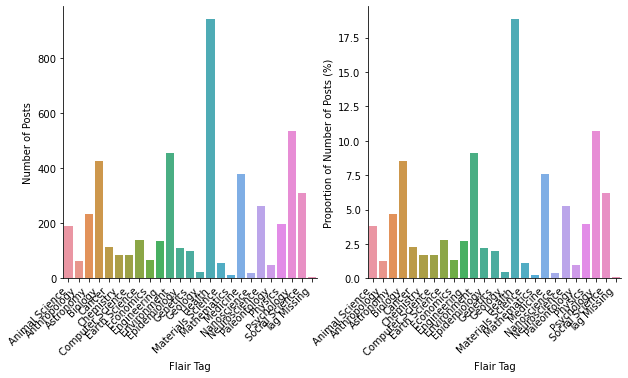

In [7]:
# Visualize the number of posts and proportion for each flair tag
list_tags = list(np.sort(df_posts_raw['link_flair_text'].unique()))

print("Figure of the number/proportion of posts in each flair tag")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5)) # sharex=True

# Number of posts
sns.countplot(
    ax=ax1, data=df_posts_raw,
    x='link_flair_text', order=list_tags
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_xlabel("Flair Tag")
ax1.set_ylabel("Number of Posts")
# ax1.set_title("Number of Posts for Each Flair Tag")
# Proportion of number of posts
prop_numposts = (df_posts_raw.groupby('link_flair_text').size() / df_posts_raw.shape[0]) * 100
sns.barplot(ax=ax2, x=prop_numposts.index, y=prop_numposts.values)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
ax2.set_xlabel("Flair Tag")
ax2.set_ylabel("Proportion of Number of Posts (%)")

sns.despine()
plt.show()

Figure of the number of comments of these posts


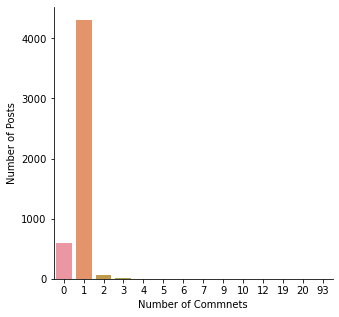

In [8]:
# Group the posts based on their number of comments
print("Figure of the number of comments of these posts")
counts_numcomm = df_posts_raw.groupby('num_comments').size()
# print(counts_numcomm)

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(x=counts_numcomm.index, y=counts_numcomm.values)
ax.set_xlabel("Number of Commnets")
ax.set_ylabel("Number of Posts")
sns.despine()
plt.show()

In [9]:
# Number of unique authors
nuniq_authors = len(df_posts_raw['author'].unique())
print("Number of unique authors: {}".format(nuniq_authors))

# Check whether there are duplicate posts with the same title
_df = df_posts_raw.drop_duplicates(subset=['title'])
if _df.shape[0] < df_posts_raw.shape[0]:
    print("There are {} duplicate posts with identical title".format(df_posts_raw.shape[0]-_df.shape[0]))
del _df

# Check whether there are duplicate posts with the same URL
_df = df_posts_raw.drop_duplicates(subset=['url'])
if _df.shape[0] < df_posts_raw.shape[0]:
    print("There are {} duplicate posts with identical URL".format(df_posts_raw.shape[0]-_df.shape[0]))
del _df

Number of unique authors: 1655
There are 217 duplicate posts with identical title
There are 458 duplicate posts with identical URL


 **Descriptive summary of posts from the science subreddit search results (raw data)**
 * Almost 20% of the posts are health-related. Psychology is the second-highest flair tag the posts belong to.
 * The majority of posts only has 1 comment
 * Many authors posted more than 1 post
 * There are some duplicate posts with identical titles and/or URL

In [10]:
# Remove duplicate posts
_df = df_posts_raw.drop_duplicates(subset=['title'])
df_posts = _df.drop_duplicates(subset=['url']).reset_index(drop=True)
del _df
print("Number of posts with unique title and URL: {}".format(df_posts.shape[0]))

Number of posts with unique title and URL: 4455


In [11]:
# Number of words in each post's title
n_words = df_posts['title'].apply(lambda x: len(x.split()))
print("Average number of words in posts' titles: {:.2f}".format(np.mean(n_words)))

Average number of words in posts' titles: 20.32


 ## Build a Reddit Post Recommender System
 For a given post, find the top 5 similar posts based on post title content

 ### Preprocessing Text Input
 * Tokenization
 * Lemmatization
 * Removing non-alphabetic and stop words

In [12]:
# Preprocessing text (using spacy)
# Tokenization, lemmatization, removing non-alphabetic word, removing English stop words
# SpaCy's pipeline packages must be downloaded first (e.g., in Terminal, type python -m spacy download en_core_web_sm)
# For efficiency, one can use the small model ('en_core_web_sm'), but it does't ship with word vectors 
# To obtain a more accurate result of similarity computation, one can use the medium ('en_core_web_md') or large 'en_core_web_lg' model
nlp = spacy.load('en_core_web_md') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# lemmas_title = [] # list of lemmas of each post's title
preprocs_title = [] # list of each post's title after lemmatization (a single sentence as a string)
for doc in nlp.pipe(df_posts['title'].tolist()):
    lemmas = [
        token.lemma_ for token in doc
        if token.lemma_.isalpha() and token.lemma_ not in stopwords
        ] 
    # lemmas_title.append(lemmas)
    preprocs_title.append(" ".join(lemmas))

# Combine the preprocessed title with relevant post information from the dataframe
df_preprocs_title = df_posts[['id']]
df_preprocs_title = df_preprocs_title.assign(preprocs_title=preprocs_title)
df_preprocs_title.head()

,id,preprocs_title
0,ujvpgv,new study find boost local location buff vacci...
1,ujvkya,remote work negatively affect productivity stu...
2,ujuk53,NASA release audio recording black hole sound ...
3,uju7iz,study find cannabis use high pregnant woman le...
4,uju0tz,hi Daniela Méndez work help people need suppor...


In [13]:
# # Tokenization
# nlp = spacy.load('en_core_web_sm') # nlp = English()
# tokens_title = []
# for title in df_posts['title']:
#     doc = nlp(title)
#     tokens = [token.text for token in doc]         
#     tokens_title.append(tokens)
# # print(tokens_title)

# # # Lemmatization (not remove non-alphabetic and stop words)
# # lemmas_title = []
# # for title in df_posts['title']:
# #     doc = nlp(title)
# #     lemmas = [token.lemma_ for token in doc]         
# #     lemmas_title.append(lemmas)
# # # print(lemmas_title)

# # Lemmatization (remove non-alphabetic and stop words)
# stopwords = spacy.lang.en.stop_words.STOP_WORDS
# lemmas_title = []
# for title in df_posts['title']:
#     doc = nlp(title)
#     lemmas = [
#         token.lemma_ for token in doc 
#         if token.lemma_.isalpha() and token.lemma_ not in stopwords
#         ]         
#     lemmas_title.append(lemmas)
# # print(lemmas_title)

 ### Approach 1: Recommendation system based on TF-IDF features

In [14]:
# Approach 1: Compute similarity between post titles based on TF-IDF vectorizer
# (1) Represent post titles in a TF-IDF matrix
# note: stop words have been removed from the step above
tfidf_vectorizer = TfidfVectorizer() #stop_words='english' #strip_accents='unicode',
tfidf_mat = tfidf_vectorizer.fit_transform(df_preprocs_title['preprocs_title'])
# (2) Compute consine similarity for each pair of posts
sim_tfidf = cosine_similarity(tfidf_mat, tfidf_mat)
# (3) Index of the posts (using post unique id)
id_posts = df_preprocs_title['id'].tolist()
# (4) Storee the consine similarity matrix as a dataframe
df_sim_tfidf = pd.DataFrame(sim_tfidf, index=id_posts, columns=id_posts)

In [15]:
# A function that return the top 5 most similar post for a given post
# Note: a consine similarity matrix must be computed in advance
def post_recommender(id_post, df_simmat, df_posts):
    # Find the ids of the top 5 posts that are most similar to the target post id
    id_posts_topsim = df_simmat.loc[id_post,:].sort_values(ascending=False)[1:6].index.tolist()
    # Extract the information of these most similar posts
    df_posts_topsim = pd.DataFrame()
    for id_post in id_posts_topsim:
        df_posts_topsim = pd.concat(
            [df_posts_topsim, df_posts.loc[df_posts['id'] == id_post, :]],
            axis=0
        )
    # Also store the consine similarity value
    simval_topsim = df_simmat.loc[id,:].sort_values(ascending=False)[1:6].rename('consine_sim')
    df_posts_topsim = df_posts_topsim.merge(
        simval_topsim.reset_index().rename(columns={'index': 'id'}), on='id'
    )
    
    return df_posts_topsim

 ### Approach 2: Recommendation system based on SpaCy's word vectors

In [16]:
# Approach 2: Compute similarity between posts based on SpaCy's word vectors
# This function computes the similarity between the title of the target post and that of any other post 
# (including the target itself) based on SpaCy's word vectors
# Then, it returns the top 5 most similar posts
def post_recommender_spacy(id_post, df_preprocs_title, df_posts):
    list_preprocs_title = df_preprocs_title['preprocs_title'].tolist()
    title_tgt = df_preprocs_title.loc[df_preprocs_title['id']==id_post, 'preprocs_title'].values[0] 
    doc_tgt = nlp(title_tgt) # target post title

    # Similarity between the target post and any other post (including itself)
    list_sim_spacy = []
    for title_other in list_preprocs_title:
        list_sim_spacy.append(doc_tgt.similarity(nlp(title_other)))

    # Pandas series of spacy similarity values
    s_sim_spacy = pd.Series(list_sim_spacy, index=id_posts).rename('cosine_sim')

    # Top 5 similar post ids
    id_posts_topsim_spacy = s_sim_spacy.sort_values(ascending=False)[1:6].index.tolist()
    # Tops 5 similar post spacy similarity values
    simval_topsim_spacy = s_sim_spacy.sort_values(ascending=False)[1:6]
    # Post information
    posts_topsim_spacy = pd.DataFrame()
    for id_post in id_posts_topsim_spacy:
        posts_topsim_spacy = pd.concat(
            [posts_topsim_spacy, df_posts.loc[df_posts['id'] == id_post, :]],
            axis=0
        )
    posts_topsim_spacy = posts_topsim_spacy.merge(
        simval_topsim_spacy.reset_index().rename(columns={'index': 'id'}), on='id'
    )
    
    return posts_topsim_spacy

In [17]:
# # Construct a similarity matrix 
# # the codes below compute pairwise similarity in for loops, which is too slow
# list_preprocs_title = df_preprocs_title['preprocs_title'].tolist()
# df_sim_spacy = pd.DataFrame(columns=df_preprocs_title['id'].tolist())
# for k, title_tgt in enumerate(list_preprocs_title):
#     doc_tgt = nlp(title_tgt) # target post title
#     # similarity between the target post and any other post (including itself)
#     list_sim_spacy = []
#     for title_other in list_preprocs_title:
#         list_sim_spacy.append(doc_tgt.similarity(nlp(title_other)))
#     # put the similarity values into a matrix
#     df_sim_spacy.loc[k,:] = list_sim_spacy
    
#     del doc_tgt

 ### Evaluate the recommenders

In [18]:
# Target post
idx_num = 0 # select 1 poster from the corpus
id = df_posts.loc[idx_num, 'id'] #1: 'ujvkya' #0: 'ujvpgv'
post_target = df_posts.loc[df_posts['id'] == id, :]

cols = ['id','author','title','subreddit','link_flair_text'] #,'url'
print("Target post:")
post_target[cols] # only show relevant columns

Target post:


,id,author,title,subreddit,link_flair_text
0,ujvpgv,Additional-Two-7312,New study finds boosting against COVID-19 in a...,science,Biology


In [19]:
# Top 5 most similar posts based on TF-IDF consine similarity
posts_topsim_tfidf = post_recommender(id, df_sim_tfidf, df_posts)

print("Top 5 similar posts (TF-IDF approach)")
posts_topsim_tfidf[cols+['consine_sim']] # only show relevant columns

Top 5 similar posts (TF-IDF approach)


,id,author,title,subreddit,link_flair_text,consine_sim
0,uj9ql9,Additional-Two-7312,New study finds vaccines induce multiple immun...,science,Biology,0.250078
1,u05gd4,AngelaJCarlos,COVID vaccine plus infection can lead to month...,science,Medicine,0.248628
2,uckktz,jonhykrazy,COVID mRNA vaccines suppress innate immunity,science,Health,0.240875
3,tg9gys,Skoltech_,"Pfizer, Moderna and Sputnik V induce better th...",science,Health,0.231810
4,uinqcf,Additional-Two-7312,New study suggests that vaccine effectiveness ...,science,Health,0.212570


In [20]:
# Top 5 most similar posts based on SpaCy word vectors consine similarity
posts_topsim_spacy = post_recommender_spacy(id, df_preprocs_title, df_posts)

print("Top 5 similar posts (SpaCy approach)")
posts_topsim_spacy[cols+['cosine_sim']] # only show relevant columns

/Users/ChiHsun/Dropbox/University of Toronto/PhD/Brainhack_Toronto_2021/brainfeed/brainfeed/reddit_recommender.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  # SQL


Top 5 similar posts (SpaCy approach)


,id,author,title,subreddit,link_flair_text,cosine_sim
0,uj9ql9,Additional-Two-7312,New study finds vaccines induce multiple immun...,science,Biology,0.853618
1,ty3gmt,Additional-Two-7312,Third dose of COVID-19 vaccine significantly i...,science,Biology,0.848778
2,u1a5pg,MistWeaver80,Fully vaccinated people had a reduced infectio...,science,Medicine,0.842615
3,uinqcf,Additional-Two-7312,New study suggests that vaccine effectiveness ...,science,Health,0.841503
4,txbhk5,Hrmbee,Protection against infection offered by fourth...,science,Medicine,0.838720


 ## Summary:
 * Similarity between reddit posts' titles were computed based on TF-IDF features and SpaCy's word vectors.
 * The recommender systems built based on TF-IDF features and SpaCy's word vectors both work well.
 * In the example above, the target post is about COVID-19 vaccines, and the top 5 similar posts returned by both models all included relevant information.
 * Note that the results are slightly different, which could be due to differences in the features/vectors used to compute the similarity.